In [1]:
import sys
sys.path.append("/global/homes/a/arosado/photometry/")

In [2]:
import os
import logging
import numpy as np
from matplotlib import pyplot as plt

from photometry import TargetSelection, utils, setup_logging

logger = logging.getLogger('DA02')
setup_logging()

plot_dir = 'plots'
run = 'north'
region = run[0].upper()
base_dir = '/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/'
data_fn = os.path.join(base_dir, 'ELGzdone_full.dat.fits')
randoms_fn = os.path.join(base_dir, 'ELGzdone_0_full.ran.fits')
hp_fn = '/global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/dark/pixweight-dark.fits'
legacysim_fn = os.path.join(os.getenv('CSCRATCH'), 'legacysim', 'dr9', 'DA02', run, 'file0_rs0_skip0', 'merged', 'matched_inputs_concatenated.fits')
logger.info('Filename: {}'.format(legacysim_fn))

[ 000000.00 ]: 07-18 09:25  DA02            INFO     Filename: /global/cscratch1/sd/arosado/legacysim/dr9/DA02/north/file0_rs0_skip0/merged/matched_inputs_concatenated.fits


# Functions

In [3]:
def isELG_colors(gflux=None, rflux=None, zflux=None, w1flux=None,
                 w2flux=None, gfiberflux=None, south=True, primary=None,
                 gmarg=0., grmarg=0., rzmarg=0.):
    """
    Apply ELG selection with box enlarged by ``gmarg``, ``grmarg``, ``rzmarg``.

    SV3 selection from https://github.com/desihub/desitarget/blob/7786db0931d23ed20de7ef37a6f07a52072e11ab/py/desitarget/sv3/sv3_cuts.py#L526
    """
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    elg = primary.copy()

    # ADM work in magnitudes instead of fluxes. NOTE THIS IS ONLY OK AS
    # ADM the snr masking in ALL OF g, r AND z ENSURES positive fluxes.
    g = 22.5 - 2.5*np.log10(gflux.clip(1e-16))
    r = 22.5 - 2.5*np.log10(rflux.clip(1e-16))
    z = 22.5 - 2.5*np.log10(zflux.clip(1e-16))
    gfib = 22.5 - 2.5*np.log10(gfiberflux.clip(1e-16))

    # ADM cuts shared by the northern and southern selections.
    elg &= g > 20 - gmarg                # bright cut.
    elg &= r - z > 0.15 - rzmarg         # blue cut.
#    elg &= r - z < 1.6 + rzmarg         # red cut.

    # ADM cuts that are unique to the north or south. Identical for sv3
    # ADM but keep the north/south formalism in case we use it later.
    if south:
        elg &= gfib < 24.1 + gmarg  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1 + grmarg  # remove stars, low-z galaxies.
    else:
        elg &= gfib < 24. + gmarg  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1 + grmarg  # remove stars, low-z galaxies.

    # ADM separate a low-priority and a regular sample.
    elgvlo = elg.copy()

    # ADM low-priority OII flux cut.
    elgvlo &= g - r < -1.2*(r - z) + 1.6 + grmarg
    elgvlo &= g - r >= -1.2*(r - z) + 1.3 - grmarg

    # ADM high-priority OII flux cut.
    elg &= g - r < -1.2*(r - z) + 1.3 + grmarg

    return elgvlo, elg


def mask_ts(self,key_flux='EFLUX',key_fiberflux='EFIBERFLUX',region=region,gmarg=0.,grmarg=0.,rzmarg=0.,gcut=-np.inf):
    mask = isELG_colors(gflux=self['{}_G'.format(key_flux)],rflux=self['{}_R'.format(key_flux)],
                        zflux=self['{}_Z'.format(key_flux)],gfiberflux=self['{}_G'.format(key_fiberflux)],south=region=='S',
                        gmarg=gmarg,grmarg=grmarg,rzmarg=rzmarg)
    mask = mask[0] | mask[1]
    mask &= self['{}_G'.format(key_flux)] > gcut
    return mask

TargetSelection.mask_ts = mask_ts

# Code

In [4]:
# legacysim
legacysim = TargetSelection.load_objects(legacysim_fn, radecbox=None, tracer='ELG', region=None)
legacysim.set_upper_case()
legacysim['RA'] = legacysim['INPUT_RA']
legacysim['DEC'] = legacysim['INPUT_DEC']
#legacysim['MATCHED'] = legacysim['DISTANCE'] < 0.15/3600.
logger.info('Found {:d}/{:d} matches.'.format(legacysim['MATCHED'].sum(),legacysim.size))
for b in legacysim.bands:
    legacysim['INPUT_EFLUX_{}'.format(b)] = utils.mag_to_flux(legacysim['INPUT_{}'.format(b)])
legacysim['INPUT_EFIBERFLUX_G'] = utils.mag_to_flux(legacysim['INPUT_GFIBER'])
legacysim.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
legacysim['EFIBERFLUX_G'] = legacysim.estimated_flux('G',key_transmission='MW_TRANSMISSION',key_flux='FIBERFLUX')
mask_tsin = legacysim.trues() #legacysim.mask_ts(key_flux='INPUT_EFLUX',key_fiberflux='INPUT_EFIBERFLUX',region=region)
#mask_tsin &= np.all([legacysim['INPUT_NOBS_{}'.format(b)] for b in ['G', 'R', 'Z']], axis=0)
mask_tsout = legacysim.mask_ts(key_flux='EFLUX',key_fiberflux='EFIBERFLUX',region=region) & legacysim['MATCHED']
#mask_tsout &= np.all([legacysim['NOBS_{}'.format(b)] for b in ['G', 'R', 'Z']], axis=0)
logger.info('Selecting {:d} (output)/{:d} (input) injected sources.'.format(mask_tsout.sum(),mask_tsin.sum()))
legacysim_data = legacysim[mask_tsout]
legacysim_randoms = legacysim[mask_tsin]

[ 000000.02 ]: 07-18 09:25  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/arosado/legacysim/dr9/DA02/north/file0_rs0_skip0/merged/matched_inputs_concatenated.fits.
[ 000031.81 ]: 07-18 09:25  TargetSelection INFO     Selecting 7502692/7502692 targets.
[ 000068.57 ]: 07-18 09:26  DA02            INFO     Found 5133267/7502692 matches.
[ 000071.72 ]: 07-18 09:26  DA02            INFO     Selecting 284207 (output)/7502692 (input) injected sources.


[ 000085.89 ]: 07-18 09:26  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/dark/pixweight-dark.fits.
[ 000086.31 ]: 07-18 09:26  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000086.96 ]: 07-18 09:26  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000086.97 ]: 07-18 09:26  HealpixDensity  INFO     Found 18641 bricks with randoms.


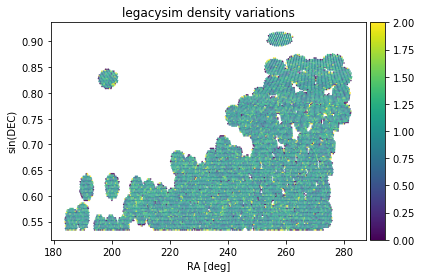

In [5]:
from photometry import Catalogue, HealpixDensity

# Density maps
map = Catalogue.load(hp_fn)
legacysim_dens = HealpixDensity(map=map)
legacysim_dens.set_randoms(randoms=legacysim_randoms)
legacysim_dens.set_properties()
legacysim_dens.set_data(data=legacysim_data)
filename = os.path.join(plot_dir,'footprint_{}.png'.format(run))
legacysim_dens.plot_density_map(title='legacysim density variations',vmin=0,vmax=2)

In [6]:
spectro = True

def mask_data_zok(data, dchi2=0.9, tsnrcut=80):
    mask = data['o2c'] > dchi2
    mask &= data['ZWARN']*0 == 0
    mask &= data['ZWARN'] != 999999
    mask &= data['LOCATION_ASSIGNED'] == 1
    mask &= data['TSNR2_ELG'] > tsnrcut
    return mask

def mask_randoms_zok(randoms, tsnrcut=80):
    mask = randoms['TSNR2_ELG'] > tsnrcut
    return mask

# ELG targets, TS applied already
bricknames = np.unique(legacysim['BRICKNAME'])
logger.info('Found {:d} bricknames'.format(bricknames.size))
data = TargetSelection.load_objects(data_fn,region=region)

mask = np.in1d(data['BRICKNAME'],bricknames)
#mask[:] = True # do not cut data on the same bricks as legacysim
data.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
data['EFIBERFLUX_G'] = data.estimated_flux('G',key_transmission='MW_TRANSMISSION',key_flux='FIBERFLUX')
data.set_mag_from_flux(key_flux='EFLUX')

mask &= data.mask_ts(key_flux='EFLUX',key_fiberflux='EFIBERFLUX',region=region)
#mask &= data.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS')
if spectro: mask &= mask_data_zok(data)
data['WEIGHT'] = data.ones()
nreal = 128
#nassign = nreal*data['PROB_OBS'] + 1. #assignment in actual observation counts
#if spectro: data['WEIGHT'] *= (nreal+1)/nassign
if spectro: data['WEIGHT'] *= 1/data['FRACZ_TILELOCID']
logger.info('Selecting {:d}/{:d} targets.'.format(mask.sum(), mask.size))
data = data[mask]

randoms = TargetSelection.load_objects(randoms_fn,region=region)
from desiutil.brick import Bricks
randoms['BRICKNAME'] = Bricks().brickname(randoms['RA'], randoms['DEC'])

mask = np.in1d(randoms['BRICKNAME'],bricknames)
#mask[:] = True
#mask &= randoms.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS')
if spectro: mask &= mask_randoms_zok(randoms)
randoms = randoms[mask]

def from_map(cat, fields):
    import healpy as hp
    map = Catalogue.load(hp_fn)
    theta,phi = utils.radec_to_thphi(cat['RA'],cat['DEC'])
    hppix = hp.ang2pix(map.header['HPXNSIDE'],theta,phi,nest=map.header['HPXNEST'],lonlat=False)
    for field in fields: cat[field] = map[field][hppix]

[ 000088.92 ]: 07-18 09:26  DA02            INFO     Found 13882 bricknames
[ 000088.92 ]: 07-18 09:26  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELGzdone_full.dat.fits.
[ 000097.37 ]: 07-18 09:26  TargetSelection INFO     Selecting 620059/1986996 targets.
<ipython-input-6-f1bb1b9a7c97>:33: RuntimeWarning: divide by zero encountered in true_divide
  if spectro: data['WEIGHT'] *= 1/data['FRACZ_TILELOCID']
[ 000099.28 ]: 07-18 09:27  DA02            INFO     Selecting 76887/620059 targets.
[ 000099.56 ]: 07-18 09:27  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELGzdone_0_full.ran.fits.
[ 000102.52 ]: 07-18 09:27  TargetSelection INFO     Selecting 604880/1909025 targets.


[ 000104.80 ]: 07-18 09:27  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/dark/pixweight-dark.fits.
[ 000105.15 ]: 07-18 09:27  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000105.80 ]: 07-18 09:27  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000105.81 ]: 07-18 09:27  HealpixDensity  INFO     Found 18641 bricks with randoms.


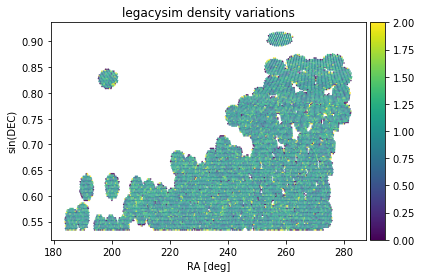

[ 000106.35 ]: 07-18 09:27  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000106.38 ]: 07-18 09:27  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000106.38 ]: 07-18 09:27  HealpixDensity  INFO     Found 16282 bricks with randoms.
[ 000106.39 ]: 07-18 09:27  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000106.99 ]: 07-18 09:27  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000106.99 ]: 07-18 09:27  HealpixDensity  INFO     Found 18641 bricks with randoms.
[ 000107.14 ]: 07-18 09:27  Properties      INFO     Calculating EBV statistics.
[ 000107.19 ]: 07-18 09:27  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.0202.
[ 000107.19 ]: 07-18 09:27  Properties      INFO     Calculating EBV statistics.
[ 000107.25 ]: 07-18 09:27  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.0204.
[ 000107.25 ]: 07-18 09:27  Properties      INFO     Calculating GALDEPTH_G statistics.
[ 

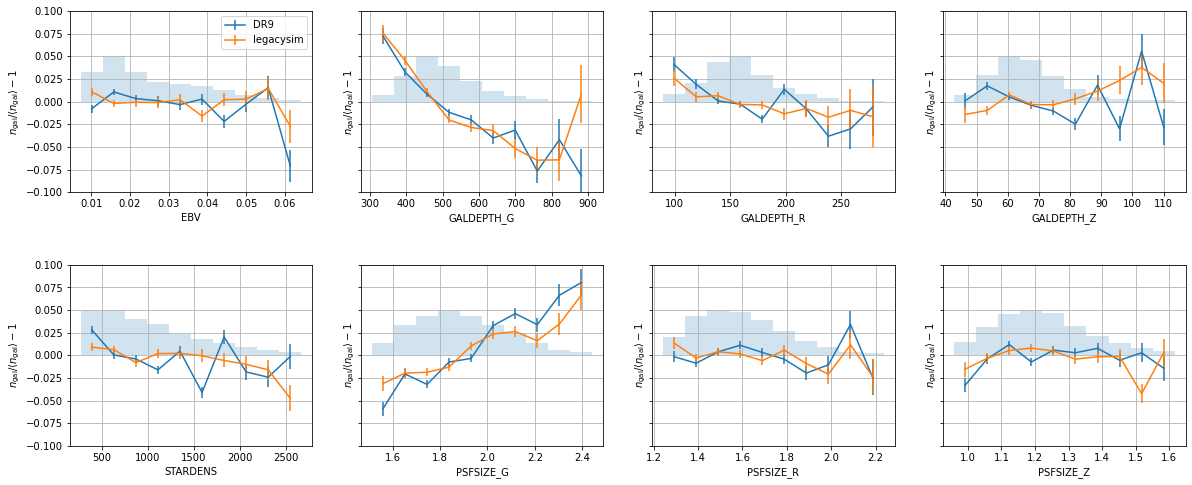

In [7]:
from photometry import Catalogue, HealpixDensity

# Density maps
map = Catalogue.load(hp_fn)
legacysim_dens = HealpixDensity(map=map)
legacysim_dens.set_randoms(randoms=legacysim_randoms)
legacysim_dens.set_properties()
legacysim_dens.set_data(data=legacysim_data)
filename = os.path.join(plot_dir,'footprint_{}.png'.format(run))
legacysim_dens.plot_density_map(title='legacysim density variations',vmin=0,vmax=2)#,path=filename)

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

dens = HealpixDensity(map=map)
#dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
dens.set_randoms(randoms=randoms)
dens.set_properties()
dens.set_data(data=data,key_weight='WEIGHT')

legacysim_dens = HealpixDensity(map=map)
#legacysim_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
legacysim_dens.set_randoms(randoms=legacysim_randoms)
legacysim_dens.set_properties()
legacysim_dens.set_data(data=legacysim_data)

others = [legacysim_dens]
labels = ['DR9','legacysim']

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(20,8))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},ylim=(-0.1,0.1),xedges={'quantiles':[0.01,0.99]})
filename = os.path.join(plot_dir,'density_{}2.png'.format(run))
#fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

In [ ]:
d = data
r = randoms

print(np.unique(data['BRICKNAME']).size, np.unique(randoms['BRICKNAME']).size)
kw = dict(s=0.2, alpha=0.05)#, color='b')
plt.scatter(d['RA'],np.sin(d['DEC']*np.pi/180),color='b',**kw)
plt.scatter(r['RA'],np.sin(r['DEC']*np.pi/180),color='r',**kw)
plt.show()

plt.scatter(r['RA'],np.sin(r['DEC']*np.pi/180),color='r',**kw)
plt.scatter(d['RA'],np.sin(d['DEC']*np.pi/180),color='b',**kw)
plt.show()

In [ ]:
ax = plt.gca()
ax.hist(legacysim['INPUT_SERSIC'], histtype='step', label='input', density=True)
ax.hist(legacysim['SERSIC'], histtype='step', label='output', density=True)
ax.hist(legacysim_data['SERSIC'], histtype='step', label='selected', density=True)
#ax.hist(data['SERSIC'], histtype='step', label='in data', density=True)
ax.legend()

In [ ]:
from photometry import Catalogue, HealpixDensity

# Density maps
map = Catalogue.load(hp_fn)

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

others = []
labels = []
for sersic in [0, 1, 4]:
    legacysim_dens = HealpixDensity(map=map)
    #legacysim_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
    legacysim_dens.set_randoms(randoms=legacysim_randoms[legacysim_randoms['INPUT_SERSIC'] == sersic])
    legacysim_dens.set_properties()
    legacysim_dens.set_data(data=legacysim_data[legacysim_data['INPUT_SERSIC'] == sersic])
    others.append(legacysim_dens)
    labels.append('$n = {:d}$'.format(sersic))

dens, others = others[0], others[1:]

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(20,8))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},ylim=(-0.1,0.1),xedges={'quantiles':[0.01,0.99]})
filename = os.path.join(plot_dir,'density_{}.png'.format(run))
#fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

[ 000458.04 ]: 07-01 08:25  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000458.08 ]: 07-01 08:25  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000458.08 ]: 07-01 08:25  HealpixDensity  INFO     Found 16282 bricks with randoms.
[ 000458.10 ]: 07-01 08:25  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000458.58 ]: 07-01 08:25  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000458.58 ]: 07-01 08:25  HealpixDensity  INFO     Found 18641 bricks with randoms.
[ 000458.61 ]: 07-01 08:25  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000470.11 ]: 07-01 08:25  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000470.11 ]: 07-01 08:25  HealpixDensity  INFO     Found 18625 bricks with randoms.
[ 000470.82 ]: 07-01 08:25  Properties      INFO     Calculating EBV statistics.
[ 000470.86 ]: 07-01 08:25  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.0202.
[ 000470.87

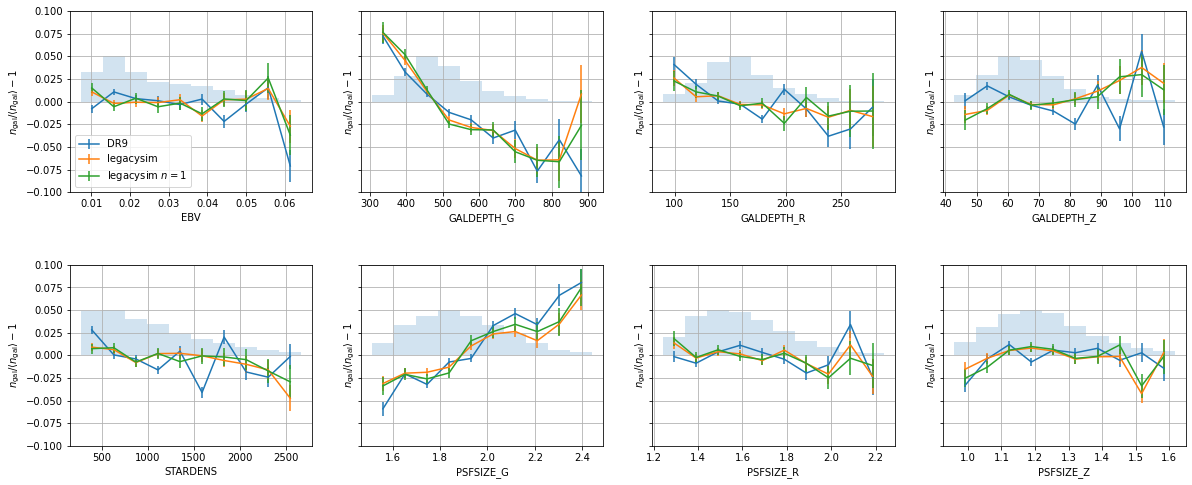

In [11]:
from photometry import Catalogue, HealpixDensity

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

dens = HealpixDensity(map=map)
#dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
dens.set_randoms(randoms=randoms)
dens.set_properties()
dens.set_data(data=data,key_weight='WEIGHT')

others = []
labels = ['DR9']

for sersic in [None, 1]:
    legacysim_dens = HealpixDensity(map=map)
    #legacysim_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
    if sersic is not None:
        legacysim_dens.set_randoms(randoms=legacysim_randoms[legacysim_randoms['INPUT_SERSIC'] == sersic])
    else:
        legacysim_dens.set_randoms(randoms=legacysim_randoms)
    legacysim_dens.set_properties()
    if sersic is not None:
        legacysim_dens.set_data(data=legacysim_data[legacysim_data['INPUT_SERSIC'] == sersic])
    else:
        legacysim_dens.set_data(data=legacysim_data)
    others.append(legacysim_dens)
    labels.append('legacysim' if sersic is None else 'legacysim $n = {:d}$'.format(sersic))

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(20,8))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},ylim=(-0.1,0.1),xedges={'quantiles':[0.01,0.99]})
filename = os.path.join(plot_dir,'density_{}.png'.format(run))
#fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

# dn/dz

In [12]:
def plot_dndz_variations(ax, z, samples, weights=None, zbins=np.linspace(0.6, 1.5, 18), linestyle='-', labels=None):

    usamples = np.unique(samples)
    nsamples = len(usamples)
    if labels is None:
        labels = [None]*nsamples
    
    dndzw = np.histogram(z, bins=zbins, weights=weights)[0]
    dndz = np.histogram(z, bins=zbins)[0]
    perr = 1./np.sqrt(dndz)*np.sqrt(nsamples)
    mid = (zbins[:-1] + zbins[1:])/2.
    ax.fill_between(mid, -perr, perr, color='gray')

    for isample, (sample, label) in enumerate(zip(usamples, labels)):
        mask = samples == sample
        dndzw_sample = np.histogram(z[mask], bins=zbins, weights=weights[mask] if weights is not None else None)[0]
        ratio = dndzw_sample.sum()/dndzw.sum()
        ax.plot(mid, 1./ratio*dndzw_sample/dndzw - 1., color='C{:d}'.format(isample), linestyle=linestyle, label=label)
    ax.set_xlabel('redshift')
    ax.set_ylabel('relative change in n(z)')
    ax.grid(True)
    ax.set_ylim(-0.3, 0.3)

[ 000500.09 ]: 07-01 08:26  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELGzdone_clustering.dat.fits.


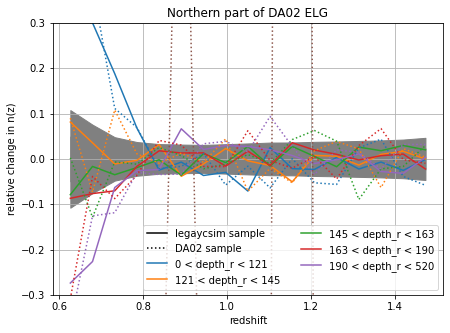

[ 000500.77 ]: 07-01 08:26  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELGzdone_clustering.dat.fits.


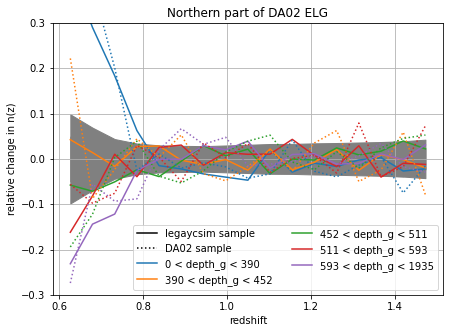

[ 000501.48 ]: 07-01 08:26  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELG_LOPnotqsozdone_clustering.dat.fits.


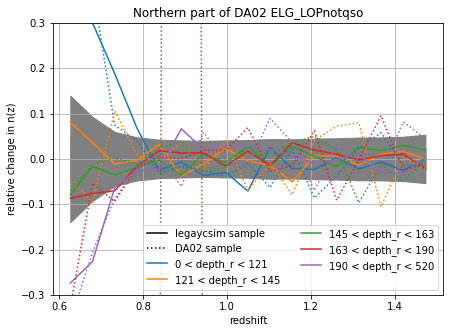

[ 000502.13 ]: 07-01 08:26  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELG_LOPnotqsozdone_clustering.dat.fits.


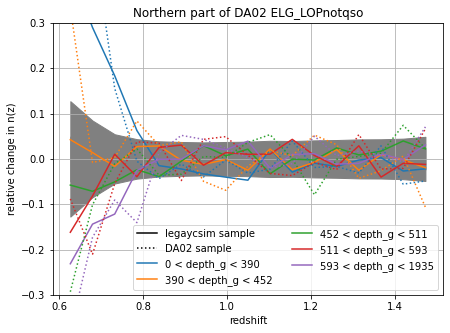

In [13]:
for prefix in ['ELG', 'ELG_LOPnotqso']:
    for column, name in [('GALDEPTH_R', 'depth_r'), ('GALDEPTH_G', 'depth_g'), ('EBV', 'ebv')][:-1]:
        z = legacysim_data['INPUT_HSC_MIZUKI_PHOTOZ_BEST']
        depth = legacysim_data[column]
        quantiles = np.quantile(depth, q=np.linspace(0., 1., 6))
        labels = ['{:.0f} < {} < {:.0f}'.format(low, name, high) for low, high in zip(quantiles[:-1], quantiles[1:])]
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        ax = plt.gca()
        fig = plt.gcf()
        fig.set_size_inches(7, 5)
        ax.plot([], [], linestyle='-', color='k', label='legaycsim sample')
        ax.plot([], [], linestyle=':', color='k', label='DA02 sample')
        plot_dndz_variations(ax, z, samples, linestyle='-', labels=labels)

        data_full = data
        data_clustering = Catalogue.load(os.path.join(base_dir, '{}zdone_clustering.dat.fits'.format(prefix)))
        ind1, ind2 = utils.overlap(data_clustering['TARGETID'], data_full['TARGETID'])
        data_clustering = data_clustering[ind1]
        z = data_clustering['Z']
        weights = data_clustering['WEIGHT_COMP']
        depth = data_full[column][ind2]
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        plot_dndz_variations(ax, z, samples, weights=weights, linestyle=':')
        ax.set_title('Northern part of DA02 {}'.format(prefix))

        ax.legend(loc=4, ncol=2)
        filename = os.path.join(plot_dir, 'dndz_{}_{}_{}.png'.format(prefix, run, name))
        #fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

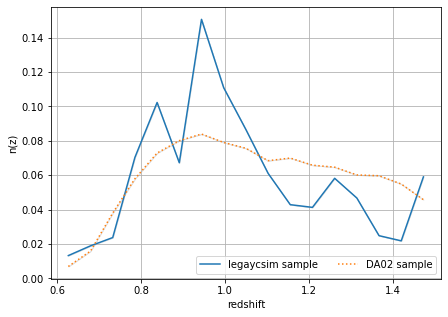

0.15866179580849837


In [14]:
def plot_dndz(ax, z, weights=None, zbins=np.linspace(0.6, 1.5, 18), linestyle='-', label=None):
    dndzw = np.histogram(z, bins=zbins, weights=weights)[0]
    dndz = np.histogram(z, bins=zbins)[0]
    perr = 1./np.sqrt(dndz)
    mid = (zbins[:-1] + zbins[1:])/2.
    norm = dndzw.sum()
    dndzw, perr = dndzw/norm, perr/norm
    ax.fill_between(mid, dndzw-perr, dndzw+perr, color='gray', alpha=0.2)
    ax.plot(mid, dndzw, linestyle=linestyle, label=label)
    ax.set_xlabel('redshift')
    ax.set_ylabel('n(z)')
    ax.grid(True)

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(7, 5)
z = legacysim_data['INPUT_HSC_MIZUKI_PHOTOZ_BEST']
plot_dndz(ax, z, linestyle='-', label='legaycsim sample')
z = data_clustering['Z']
weights = data_clustering['WEIGHT_COMP']
plot_dndz(ax, z, weights=weights, linestyle=':', label='DA02 sample')
ax.legend(loc=4, ncol=2)
plt.show()
print((z<0.8).sum()*1./z.size)

In [15]:
print(np.unique(legacysim_data['INPUT_HSC_DEMP_PHOTOZ_BEST']))

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95
 1.96 

In [16]:
hsc_dir = '/global/cfs/cdirs/desi/target/analysis/truth/parent'
hsc_fn = os.path.join(hsc_dir,'hsc-pdr2-dud-cosmos-reduced.fits')
hsc = Catalogue.load_fits(hsc_fn)
#print(hsc.fields)
print(np.unique(hsc['mizuki_photoz_best']).size)

[ 000568.15 ]: 07-01 08:27  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/target/analysis/truth/parent/hsc-pdr2-dud-cosmos-reduced.fits.


642
